In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from lifelines import KaplanMeierFitter

In [2]:
datadir = os.path.join('..', 'data', 'modeling', 'predict')
adata = sc.read_h5ad(os.path.join(datadir, 'TCGA_SKCM.h5ad'))
adata

AnnData object with n_obs × n_vars = 473 × 856
    obs: 'id', 'disease_type', 'case_id', 'submitter_id', 'primary_site', 'alcohol_history.exposures', 'race.demographic', 'gender.demographic', 'ethnicity.demographic', 'vital_status.demographic', 'age_at_index.demographic', 'days_to_birth.demographic', 'year_of_birth.demographic', 'year_of_death.demographic', 'primary_site.project', 'project_id.project', 'disease_type.project', 'name.project', 'name.program.project', 'tissue_source_site_id.tissue_source_site', 'code.tissue_source_site', 'name.tissue_source_site', 'project.tissue_source_site', 'bcr_id.tissue_source_site', 'days_to_death.demographic', 'entity_submitter_id.annotations', 'notes.annotations', 'submitter_id.annotations', 'classification.annotations', 'entity_id.annotations', 'created_datetime.annotations', 'annotation_id.annotations', 'entity_type.annotations', 'updated_datetime.annotations', 'case_id.annotations', 'state.annotations', 'category.annotations', 'status.annotatio

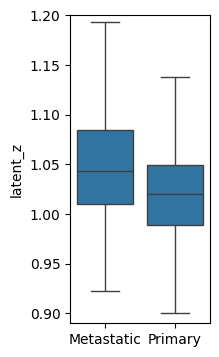

1.0365168769627562e-05


In [6]:
fig, ax = plt.subplots(1, 1, figsize = (1.8, 4))
sns.boxplot(adata.obs,
            x = 'tumor_descriptor.samples',
            y = 'latent_z',
            order = ['Metastatic', 'Primary'],
            fliersize = 0, ax = ax)
ax.set_ylim(.89, 1.2)
ax.set_xlabel('')
plt.show()

cat = adata.obs['tumor_descriptor.samples']
msk_primary = (cat == 'Primary')
msk_metastatic = (cat == 'Metastatic')
z_primary = adata[msk_primary].obs.latent_z
z_metastatic = adata[msk_metastatic].obs.latent_z
print(mannwhitneyu(z_metastatic, z_primary).pvalue)

/tmp/ipykernel_1542276/1272231688.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('_PATIENT').agg(aggdict)


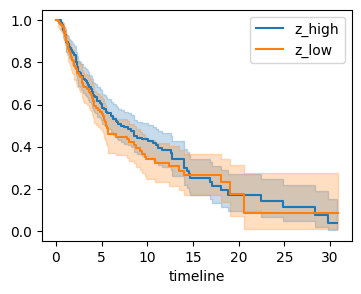

In [9]:
colnames = {'OS'       : float,
            'OS.time'  : float,
            'latent_z' : float,
            '_PATIENT' : 'category'}

aggdict = {'OS'       : 'first',
           'OS.time'  : 'first',
           'latent_z' : 'mean'}

df = adata.obs.copy()
df = df[colnames.keys()].copy()
for key, val in colnames.items():
    df[key] = df[key].astype(val)
df = df.groupby('_PATIENT').agg(aggdict)
df.dropna(axis = 0, inplace = True)
df['OS.time'] /= 365.

plt.figure(figsize = (4, 3))
kmf = KaplanMeierFitter()
ix = df.latent_z > df.latent_z.median()
kmf.fit(df.loc[ix, 'OS.time'], df.loc[ix, 'OS'], label = 'z_high')
ax = kmf.plot_survival_function()

kmf.fit(df.loc[~ix, 'OS.time'], df.loc[~ix, 'OS'], label = 'z_low')
ax = kmf.plot_survival_function()